#### Cluster Analysis based on Clusters found on Subsample with DBSCAN

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

# NLP Stuff
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# WordClouds
from utils.wordcloud import plot_wordcloud

In [2]:
cluster_data = pd.read_pickle("../data/tweets_clustered.pickle")

In [3]:
# Set up tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Set stop words
stop_words = set(stopwords.words('english')) 

In [4]:
cluster_counts = cluster_data.groupby("dbscan_label").count()["userid"]

In [5]:
cluster_counts

dbscan_label
-1     26774
 0       363
 1      9092
 2      2112
 3       333
 4       145
 5       155
 6        26
 7        24
 8       170
 9       115
 10       20
 11       22
 12       38
 13      160
 14       25
 15       34
 16       98
 17       59
 18       34
 19       14
 20       49
 21       41
 22       20
 23       28
 24       24
 25        9
 26       16
Name: userid, dtype: int64

The -1 is the "noise" cluster

In [26]:
def visualize_cluster(cluster, savepath = None):
    
    # Get subset
    data  = cluster_data[cluster_data.dbscan_label == cluster]
    
    # Tokenize, remove stopwords
    tweets_tokenized = [tokenizer.tokenize(t) for t in data["tweet_text"]]

    # Remove stopwords
    tweets_tokenized_noSwords = np.array([[w for w in tweet_tokens if w not in stop_words] for tweet_tokens in tweets_tokenized])
    
    # Plot Wordcloud
    plot_wordcloud(tweets_tokenized_noSwords,savepath)

### Visualization of some of the clusters identified by DBSCAN 

In [ ]:
# Noise
visualize_cluster(-1,savepath="../img/DBSCAN_noise_cluster.png")

In [ ]:
# Police brutality
visualize_cluster(0,savepath="../img/DBSCAN_police_brutality.png")

In [ ]:
# Workout
visualize_cluster(1,savepath="../img/DBSCAN_workout.png")

In [ ]:
# Nuclear
visualize_cluster(2,savepath="../img/DBSCAN_nuclear.png")

In [ ]:
# Veterans
visualize_cluster(4,savepath="../img/DBSCAN_veterans.png")

In [ ]:
# The food issue
visualize_cluster(5,savepath="../img/DBSCAN_food_poisoning.png")

In [ ]:
# Stock market
visualize_cluster(7,savepath="../img/DBSCAN_stock_market.png")

In [ ]:
# Trump investigation
visualize_cluster(8,savepath="../img/DBSCAN_trump_investigation.png")

In [ ]:
# Selfie cluster
visualize_cluster(13,savepath="../img/DBSCAN_selfie.png")

In [ ]:
# Health Care cluster
visualize_cluster(16,savepath="../img/DBSCAN_healthcare.png")

In [ ]:
# Drug Cluster 
visualize_cluster(20,savepath="../img/DBSCAN_drugs.png")

### Identifying polarization through cosine similarity

- Cluster inside of the BlackLivesMatter / Police Cluster
- Is there significant dissimilarity
- Compare to dissimiliarity inside the noise cluster

In [20]:
noise_cluster = cluster_data[cluster_data.dbscan_label == -1]
police_cluster = cluster_data[cluster_data.dbscan_label == 0]
investigation_cluster = cluster_data[cluster_data.dbscan_label == 8]

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
# Columns containing the embedding information
embedding_cols = [str(i) + "_dim" for i in range(0,100)]

In [21]:
X_noise = noise_cluster.loc[:,embedding_cols].values
X_police = police_cluster.loc[:,embedding_cols].values
X_investigation =investigation_cluster.loc[:,embedding_cols].values

In [16]:
# Compute average pairwise cosine_similarity
avg_cosine_noise = np.mean(cosine_similarity(X_noise))

In [17]:
avg_cosine_noise

0.49665159157272215

In [18]:
avg_cosine_police = np.mean(cosine_similarity(X_police))
print(avg_cosine_police)

0.7757970674068988


### Comparing Cosine Similarities across clusters

In [ ]:
cluster_data[cluster_data.dbscan_label == 20]["tweet_text"][2269445]

In [97]:
to_compare = [-1,0,8,16,18,20,24,26]

cluster_names= ["noise","police","russiaInvestigation","healthCareBill","travelBan","drugs","gop","supremecourt"]

In [100]:
similarity_df = pd.DataFrame(columns=cluster_names,index=cluster_names)

In [101]:
for i, cluster1 in enumerate(to_compare):
    print(cluster_names[i])
    x1 = cluster_data[cluster_data.dbscan_label == cluster1][embedding_cols].values
    
    
    
    for j, cluster2 in enumerate(to_compare):
        x2 = cluster_data[cluster_data.dbscan_label == cluster2][embedding_cols].values
        
        similarity_df.loc[cluster_names[i],cluster_names[j]] = np.mean(cosine_similarity(x1,x2))

noise
police
russiaInvestigation
healthCareBill
travelBan
drugs
gop
supremecourt


In [105]:
similarity_df

,noise,police,russiaInvestigation,healthCareBill,travelBan,drugs,gop,supremecourt
noise,0.496652,0.506928,0.499311,0.50562,0.484446,0.488452,0.49994,0.465996
police,0.506928,0.775797,0.555102,0.527913,0.534972,0.501133,0.518546,0.500995
russiaInvestigation,0.499311,0.555102,0.769458,0.69269,0.665659,0.492671,0.648445,0.671938
healthCareBill,0.50562,0.527913,0.69269,0.821545,0.685892,0.568309,0.702181,0.717526
travelBan,0.484446,0.534972,0.665659,0.685892,0.852222,0.517225,0.611342,0.727672
drugs,0.488452,0.501133,0.492671,0.568309,0.517225,0.839435,0.507285,0.479997
gop,0.49994,0.518546,0.648445,0.702181,0.611342,0.507285,0.844767,0.654554
supremecourt,0.465996,0.500995,0.671938,0.717526,0.727672,0.479997,0.654554,0.866883


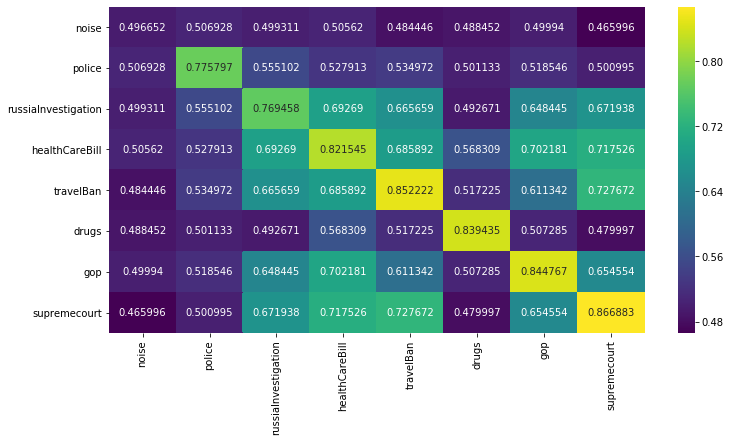

In [115]:
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(similarity_df[similarity_df.columns].astype(float) , annot=True, fmt="g", cmap='viridis', ax= ax)
fig.savefig("../img/heatmap_cluster_similarity")

### Can we find clusters within clusters?

In [ ]:
to_compare = [-1,0,8,16,18,20,24,26]

cluster_names= ["noise","police","russiaInvestigation","healthCareBill","travelBan","drugs","gop","supremecourt"]

In [139]:
cluster = cluster_data[cluster_data.dbscan_label == 0].copy()

In [140]:
# Finding optimal eps based on k-distance graph
from sklearn.cluster import DBSCAN, KMeans


X = blm_cluster.loc[:,embedding_cols].values

# Set up the DBSCAN algorithm
#dbscan = DBSCAN(eps =1,min_samples= 4,metric ="euclidean",n_jobs=4)

# Fit on our data
#dbscan.fit(X)

kmeans = KMeans(n_clusters=2)

kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [141]:
cluster["kmeans_label"] = kmeans.labels_

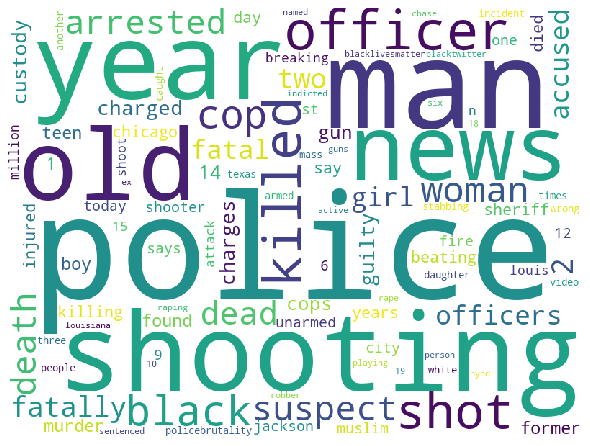

In [143]:
# Get subset
data  = cluster[cluster.kmeans_label == 0]

# Tokenize, remove stopwords
tweets_tokenized = [tokenizer.tokenize(t) for t in data["tweet_text"]]

# Remove stopwords
tweets_tokenized_noSwords = np.array([[w for w in tweet_tokens if w not in stop_words] for tweet_tokens in tweets_tokenized])

# Plot Wordcloud
plot_wordcloud(tweets_tokenized_noSwords,None)

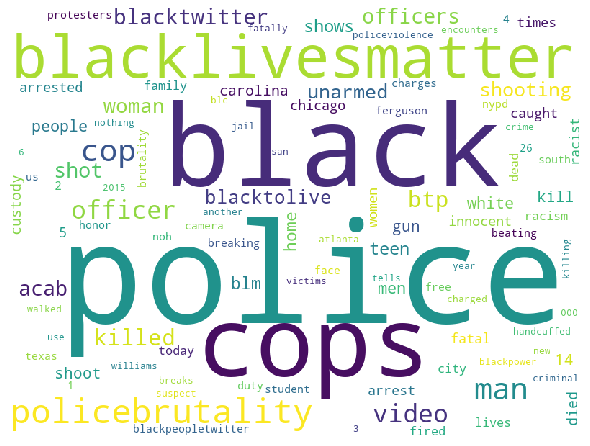

In [144]:
# Get subset
data  = cluster[cluster.kmeans_label == 1]

# Tokenize, remove stopwords
tweets_tokenized = [tokenizer.tokenize(t) for t in data["tweet_text"]]

# Remove stopwords
tweets_tokenized_noSwords = np.array([[w for w in tweet_tokens if w not in stop_words] for tweet_tokens in tweets_tokenized])

# Plot Wordcloud
plot_wordcloud(tweets_tokenized_noSwords,None)